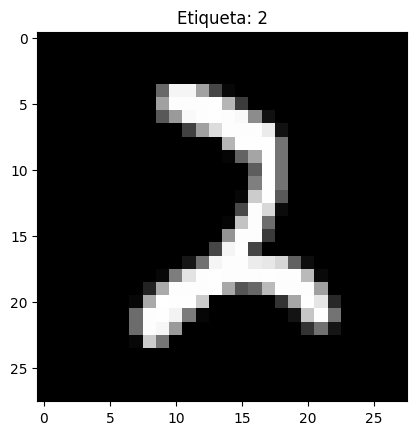

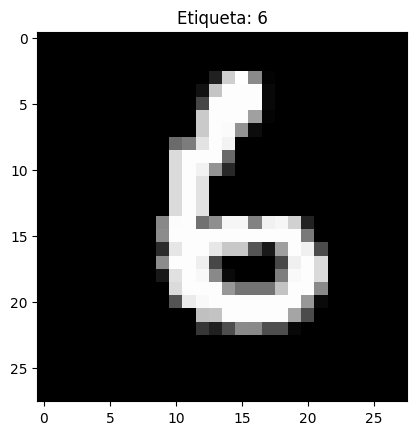

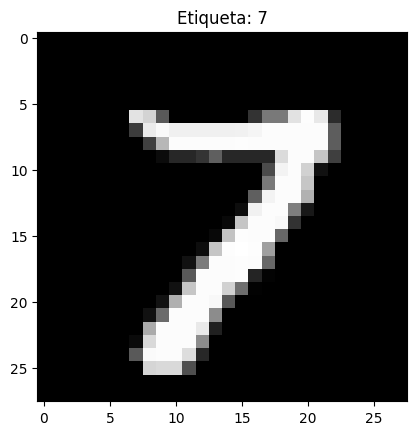

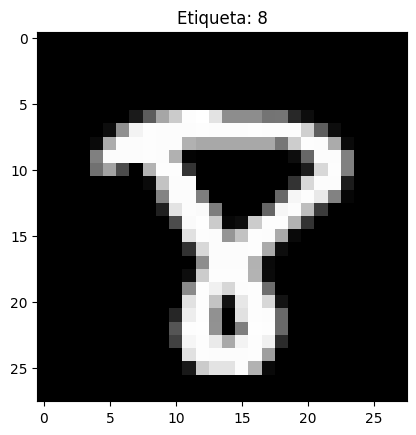

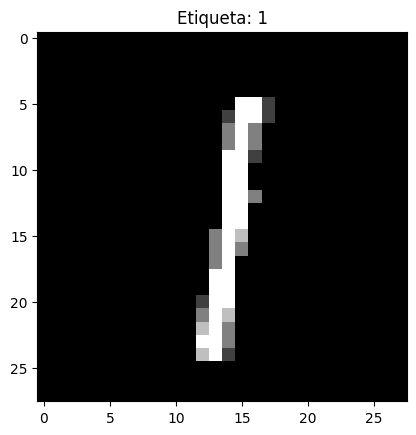

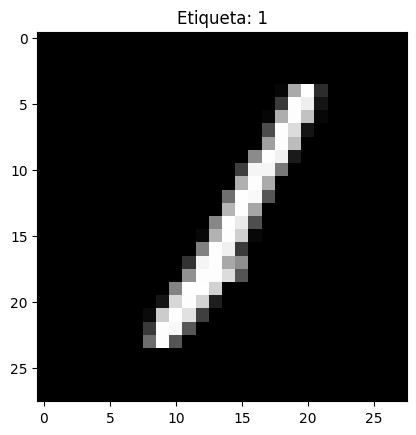

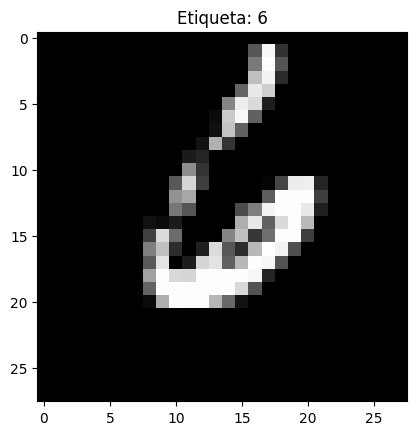

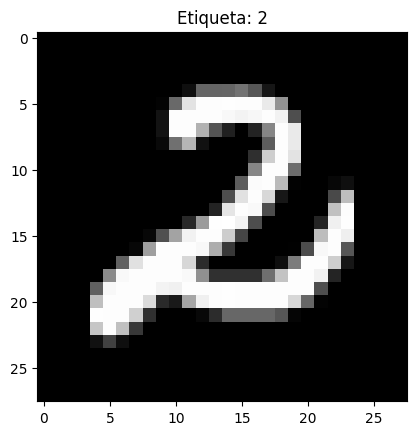

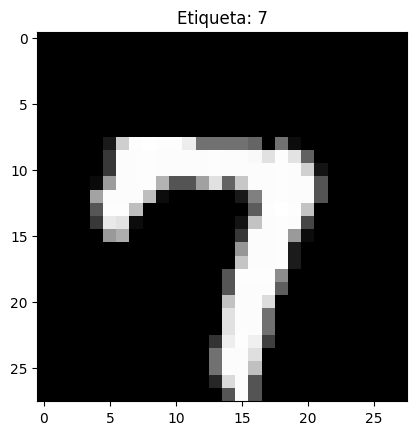

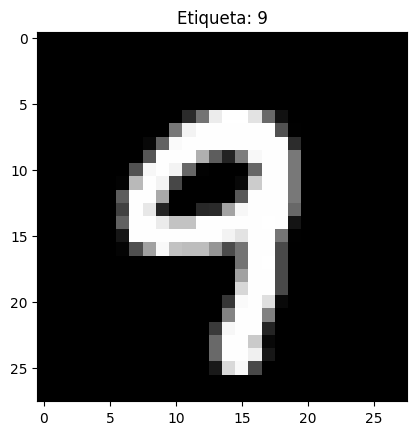

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Cargo los datos de train y test
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Elijo y muestro imagenes al azar
indices = np.random.choice(len(x_test), 10, replace=False)
for i in indices:
  plt.imshow(x_test[i], cmap='gray')
  plt.title(f"Etiqueta: {y_test[i]}")
  plt.show()



In [ ]:
#Genero etiquetas par o impar (0=par, 1=impar)
y_train_bin = y_train % 2
y_train_bin = y_train_bin.reshape(-1,1)
y_test_bin = y_test % 2
y_test_bin = y_test_bin.reshape(-1,1)

In [ ]:
class Normalizar:
  def __init__(self):
    self.mean = None
    self.std = None
    self.indices = None

  def fit(self, X):
    #Tomo medias y varianzas
    self.mean = X.mean(axis=0)
    self.std = X.std(axis=0)

    #Guardo los indices con varianzas distintas de 0
    self.indices = np.where(self.std > 0)[0]
    self.std = self.std[self.indices]
    self.mean = self.mean[self.indices]

  def transform(self, X):
    X = X[:, self.indices]

    #Normalizo
    X_norm = (X - self.mean) / self.std
    return X_norm


  def fit_transform(self, X):
    self.fit(X)
    return self.transform(X)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test  = x_test.reshape(x_test.shape[0], -1)

#Normalizo
norm = Normalizar()

x_train_n = norm.fit_transform(x_train)
x_test_n = norm.transform(x_test)



#Analisis Teórico

##Cálculo de $\sigma^{-1}(p)$

$$ \sigma(z) = p = \frac{1}{1 + e^{-z}} \Rightarrow e^{-z} = \frac{1}{p} - 1 \Rightarrow z = -\ln(\frac{1}{p} - 1)$$

$$\sigma^{-1}(p) = \ln(\frac{p}{1-p})$$


##Cálculo $\sigma'(z)$

$$\sigma'(z) = \left(\frac{1}{1+e^{-z}}\right)' = \left(-\frac{1}{(1+e^{-z})^2}\right)\,(-e^{-z}) = \sigma(z)\,\frac{(1+e^{-z}-1)}{1+e^{-z}} = \sigma(z)(1 - \sigma(z))$$

##Costo

El costo se define con la funcion log-loss ($x_{ext} = [1 \quad x]^T$

$$l(x, y) = -\log{(\hat{p}(y|x))} = -\log{(\sigma(\bar{w}\,x_{ext})^y(1-\sigma(\bar{w}\,x_{ext}))^{(1-y)})} = -y\,\log{(\sigma(\bar{w}\,x_{ext}))} - (1-y)\log{(1-\sigma(\bar{w}\,x_{ext}))}$$

El gradiente se calcula

$$\frac{\partial l(w)}{\partial w} = x_{ext}\left[-\frac{y}{\sigma(\bar{w}\,x_{ext})} - \frac{1 - y}{1 - \sigma(\bar{w}\,x_{ext})} \right](1-\sigma(\bar{w}\,x_{ext}) \sigma(\bar{w}\,x_{ext}) $$

El riesgo empirico es la esperanza del costo:

$$J(\bar{w}) = \frac{1}{n}\sum_{i = 0}^n l(x_i, y_i)$$

Y el gradiente de este es:

$$\frac{\partial J(\bar{w})}{\partial \bar{w}} = \frac{1}{n}\sum_{i = 0}^n \frac{\partial l(\bar{w})}{\partial \bar{w}}$$



In [ ]:
class RegresionLogistica:
  def __init__(self, lr, iter):
    #Defino parametros
    self.params = None
    self.lr = lr
    self.iter = iter
    self.hist_riesgo = []

  def fit(self, X, y):
    #Tomo la cantidad de muestras
    n = len(X)
    #Genero el array para los parametros
    self.params = np.zeros((X.shape[1] + 1, 1))

    #Extiendo X
    X_ext = np.hstack((np.ones((n,1)), X))
    for i in range(0, self.iter):
      #Calculo el gradiente
      exponente = X_ext @ self.params
      factor = (1/(1 + np.exp(-exponente)) - y.reshape(-1,1))
      grad_J = (X_ext.T @ factor)/n

      #Actualizo los parametros
      self.params = self.params - self.lr * grad_J

      #Calculo el riesgo y lo guardo
      riesgo = -(y.T @ np.log(1/(1 + np.exp(-exponente))) + (1-y).T @ np.log(1 - 1/(1 + np.exp(-exponente))))/n
      riesgo = riesgo.reshape(1)
      self.hist_riesgo.append(riesgo)


  def predict_proba(self, X):
    #Devuelve la proba de que X sea impar
    n = len(X)
    X_ext = np.hstack((np.ones((n,1)), X))
    exponente = X_ext @ self.params
    return 1/(1 + np.exp(-exponente))

  def predict(self, X):
    n = len(X)
    #Chequeo si mi w*x da mayor a 0 y en base a eso decido
    X_ext = np.hstack((np.ones((n,1)), X))
    es_impar = X_ext @ self.params > 0
    return es_impar.astype(int)

  def accuracy(self, X, y):
    #Veo la proporcion de aciertos
    y_pred = self.predict(X)
    return np.mean((y_pred == y).astype(int))

  def cross_entropy(self, X, y):
    #Calculo la entropía cruzada como el promedio de los costos de cada muestra
    n = len(X)
    X_ext = np.hstack((np.ones((n,1)), X))
    exponente = X_ext @ self.params
    return -(y.T @ np.log(1/(1 + np.exp(-exponente))) + (1-y).T @ np.log(1 - 1/(1 + np.exp(-exponente))))/n


In [ ]:
reg = RegresionLogistica(0.7, 100)
#Entreno
reg.fit(x_train_n, y_train_bin)


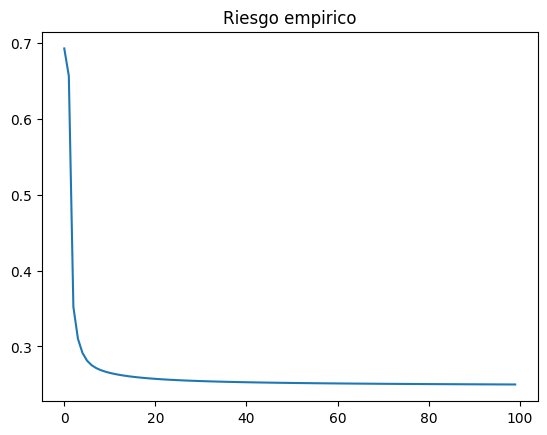

El accuracy de train es:0.9029166666666667
La entropía cruzada para el train es:[[0.24974047]]
El accuracy de testeo es:0.9022
La entropía cruzada para el testeo es:[[0.25568921]]


In [ ]:
#Grafico el riesgo empirico para verificar convergencia
plt.plot(reg.hist_riesgo)
plt.title("Riesgo empirico")
plt.show()



test = reg.predict(x_test_n)

print("El accuracy de train es:" + str(reg.accuracy(x_train_n, y_train_bin)))
print("La entropía cruzada para el train es:" + str(reg.cross_entropy(x_train_n, y_train_bin)))

print("El accuracy de testeo es:" + str(reg.accuracy(x_test_n, y_test_bin)))
print("La entropía cruzada para el testeo es:" + str(reg.cross_entropy(x_test_n, y_test_bin)))



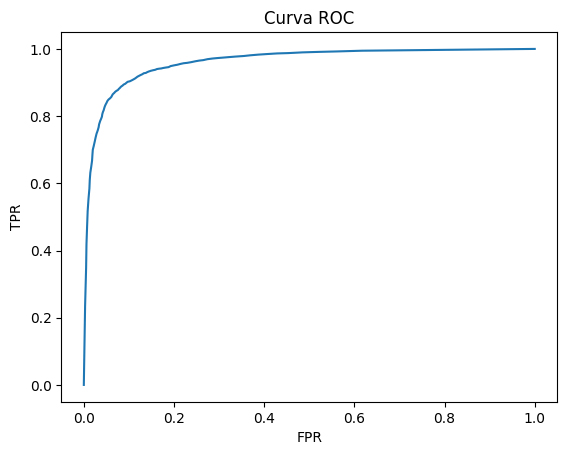

In [ ]:
#Curva ROC

#Defino umbrales y hago prediccion soft
umbrales = np.linspace(0, 1, 100)
proba = reg.predict_proba(x_test_n)

TPR = []
FPR = []

for t in umbrales:
    y_pred = (proba >= t).astype(int)

    #Calculo TPR y FPR
    TP = np.sum((y_test_bin == 1) & (y_pred == 1))
    P = np.sum((y_test_bin == 1))
    FP = np.sum((y_test_bin == 0) & (y_pred == 1))
    N = np.sum((y_test_bin == 0))

    tpr = TP / P
    fpr = FP / N

    TPR.append(tpr)
    FPR.append(fpr)


plt.plot(FPR, TPR)
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
